In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2023-10-30 22:46:09.010446: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 22:46:09.010622: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 22:46:09.011229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 22:46:09.067059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-10-30 22:46:12.427632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:46:12.451357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:46:12.451516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Leer Dataset (Image + mask)

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
ruta = '../Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg'
rutas_dataset  = glob.glob('../../../Datasets/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[6]
    number = ruta_list[7]
    tipo = ruta_list[8]
    name = ruta_list[9].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', '- secas: ', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 923
MF1: - secas:  378
MF2: - secas:  284
MF3: - secas:  261


,name,route_image,label,number,route_mask
380,IMG_20230707_184708_jpg,../../../Datasets/Micrografías segmentaciones/...,0,6,../../../Datasets/Micrografías segmentaciones/...
453,IMG_20230707_191626_jpg,../../../Datasets/Micrografías segmentaciones/...,0,7,../../../Datasets/Micrografías segmentaciones/...
923,IMG_20230711_223133_jpg,../../../Datasets/Micrografías segmentaciones/...,2,5,../../../Datasets/Micrografías segmentaciones/...
78,IMG_20230602_221313_jpg,../../../Datasets/Micrografías segmentaciones/...,2,4,../../../Datasets/Micrografías segmentaciones/...
437,IMG_20230707_191407_jpg,../../../Datasets/Micrografías segmentaciones/...,0,7,../../../Datasets/Micrografías segmentaciones/...
...,...,...,...,...,...
241,IMG_20230707_171125_jpg,../../../Datasets/Micrografías segmentaciones/...,0,3,../../../Datasets/Micrografías segmentaciones/...
859,IMG_20230711_214638_jpg,../../../Datasets/Micrografías segmentaciones/...,2,6,../../../Datasets/Micrografías segmentaciones/...
214,IMG_20230707_170741_jpg,../../../Datasets/Micrografías segmentaciones/...,0,3,../../../Datasets/Micrografías segmentaciones/...
843,IMG_20230711_212848_jpg,../../../Datasets/Micrografías segmentaciones/...,2,7,../../../Datasets/Micrografías segmentaciones/...


In [4]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


In [5]:
def get_contours_and_features(binary_map):
    #contours_map  = np.zeros_like(binary_map)
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contours_map = cv2.drawContours(contours_map, contours, -1, 255, 1)
    contours_features = []
    for contour in contours:
        error = 1e-5

        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        features = {
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features    
    return contours_features

def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    atributes = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)        

        ## obtener área de poros
        area = np.ceil(np.sum(get_item(contour_features, key='area')))

        ## obtener perímetro de poros
        perimetro = np.ceil(np.sum(get_item(contour_features, key='perimeter'))
)
        ## intersticio
        area_total = np.ceil(np.shape(image)[0] * np.shape(image)[1])
        intersticio = np.ceil(area_total - area)

        ## Cantidad de poros
        poros = np.shape(contour_features)[0]

        #atributes = [area,perimetro,intersticio,poros]
        atributes.append([area,perimetro,intersticio,poros])
    
    return atributes

def create_dataset(buffer,file_names, labels, file_mask):    
  images = get_binary_image(file_mask)
  attributes = get_geometric_atributes(images)
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes ))
  dataset.shuffle(buffer_size=buffer)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes ))
  
  return dataset

file_names = train_df['route_image'].to_numpy()
file_mask = train_df['route_mask'].to_numpy()
labels = train_df['label'].to_numpy()
dataset = create_dataset(16,file_names, labels,file_mask)

2023-10-30 22:46:20.479639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:46:20.479785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 22:46:20.479880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[ 5965.  1954. 10419.    38.]
b'0'


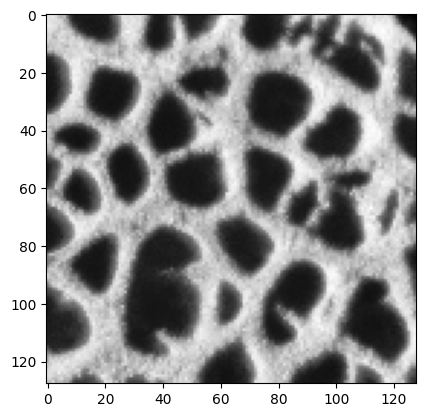

In [6]:
cnt = 0
for i in dataset.batch(16):
    a = i[0]
    b = i[1]
    c = i[2]

n =  0
print(c[n].numpy())
print(b[n].numpy())
plt.imshow(a[n],cmap='gray')

## Modelo

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, regressor, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.regressor = regressor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")        
        self.estimation_loss_tracker = keras.metrics.Mean(name="estimation_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.estimation_loss_tracker,            
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            ## Valores estimados por el encoder
            z_mean, z_log_var, z = self.encoder(data[0])
            
            ## Valores geométricos asociados a los datos
            geometrics_features = data[2]

            ## Reconstrucción del embebido del encoder
            reconstruction = self.decoder(z)

            ## Valores estimados apartir del regresor
            estimation = self.regressor(z)

            ## Reducción de la reconstrucción
            reconstruction /= tf.reduce_max(reconstruction)
            
            ## Error de reconstrucción
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
            )

            '''
            reconstruction_loss =tf.reduce_mean(
                tf.reduce_sum( tf.keras.losses.MeanSquaredError()(data, reconstruction)
                             )
            )
            '''
            
            ## Error de estimación de valores geométricos
            estimation_loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(geometrics_features, estimation))
            
            
            ## Error de divergencia KL
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))   

            ## Error total          
            total_loss = reconstruction_loss + kl_loss + estimation_loss
        
        ## Actualización de los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)

        ## Actualización de lA RECONSTRUCCIÓN
        self.reconstruction = reconstruction

        ### Actualización de los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)   
        self.estimation_loss_tracker.update_state(estimation_loss)    
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(), 
            "ArithmeticError": self.estimation_loss_tracker.result(),        
        }

In [8]:
###_____________________________ENCODER________________________##
latent_dim = 32

nx, ny = 128, 128

encoder_inputs = keras.Input(shape=(nx, ny,1))

x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',name='layer_E1')(encoder_inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',name='layer_E2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',name='layer_E3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',name='layer_E4')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='layer_E6')(x)
x = layers.Flatten()(x)



z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 layer_E1 (Conv2D)           (None, 128, 128, 1024)       10240     ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 1024)         0         ['layer_E1[0][0]']            
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 1024)         4096      ['max_pooling2d[0][0]'] 

In [9]:
## Entrada Z
latent_inputs = keras.Input(shape=(latent_dim,))

##dimensiones
ndim = 16
nfilts = 128

## anti-flatten de la última capa convolucional
x = layers.Dense(ndim * ndim * nfilts, activation="relu")(latent_inputs)

## Reshape para reconstruir la última convolucional
x = layers.Reshape((ndim,ndim, nfilts))(x)

## Capas convolucionales
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='layer_D1')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='layer_D2')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='layer_D4')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',name='layer_D6')(x)

decoder_outputs = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='layer_D7')(x)

## Construcción del decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 layer_D1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 up_sampling2d (UpSampling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                          

In [10]:
### Estimador de valores geométricos

## Input layer
regressor_inputs = keras.Input(shape=(latent_dim,))

## Hidden layers
x = layers.Dense(16, activation="relu")(regressor_inputs)
x = layers.Dense(8, activation="relu")(x)

## Output layer
regressor_outputs = layers.Dense(4, activation="relu")(regressor_inputs)

## regressor model
regressor = keras.Model(regressor_inputs, regressor_outputs, name="regressor")
regressor.summary()


Model: "regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 132 (528.00 Byte)
Trainable params: 132 (528.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
vae = VAE(encoder, decoder,regressor)
opt = tf.optimizers.Adam(learning_rate = 0.000001)
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(dataset.batch(16), epochs=2000, 
                batch_size=16,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)])

Epoch 1/2000


2023-10-30 22:47:59.398176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-30 22:48:01.483957: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efa3c12fb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-30 22:48:01.483979: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-10-30 22:48:01.494236: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-30 22:48:01.600087: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-10-30 22:48:06.644031: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate 

47/47 [==============================] - 24s 178ms/step - loss: 36772590.0833 - reconstruction_loss: 48268.4961 - kl_loss: 0.0027 - ArithmeticError: 36723934.8333
Epoch 2/2000
47/47 [==============================] - 6s 128ms/step - loss: 36772116.6667 - reconstruction_loss: 48016.2695 - kl_loss: 0.0063 - ArithmeticError: 36723848.9167
Epoch 3/2000
47/47 [==============================] - 6s 128ms/step - loss: 36771933.0833 - reconstruction_loss: 47427.6602 - kl_loss: 0.0176 - ArithmeticError: 36724067.7500
Epoch 4/2000
47/47 [==============================] - 6s 128ms/step - loss: 36770000.5833 - reconstruction_loss: 46898.7031 - kl_loss: 0.0577 - ArithmeticError: 36722904.5833
Epoch 5/2000
47/47 [==============================] - 6s 129ms/step - loss: 36768548.6667 - reconstruction_loss: 46412.6523 - kl_loss: 0.2160 - ArithmeticError: 36722296.8333
Epoch 6/2000
47/47 [==============================] - 6s 130ms/step - loss: 36765509.6667 - reconstruction_loss: 45568.4023 - kl_loss: 0.

In [12]:
### Guardar modelohttps://www.tensorflow.org/guide/saved_model?hl=es-419
vae.encoder.save('Models/weaklyGVAE_encoder_DRY_3_32.h5')
vae.decoder.save('Models/weaklyGVAE_decoder_DRY_3_32.h5')
vae.regressor.save('Models/weaklyGVAE_regressor_DRY_3_32.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
